# Implementation of learning sine function
Based upon: https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning/

In [1]:
# imports
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

import numpy as np
import matplotlib.pyplot as plt

## Construct variational circuit (state_preparation + ansatz)¶¶

In [2]:
# We use the datapoint as angle for state-preparation
# We have 3 parameters for Rotation -> all states on bloch-sphere can be reached!

datapoint = Parameter('data')
params = ParameterVector('param', 3)

qc = QuantumCircuit(1,1)
qc.rx(datapoint, 0)
qc.rz(params[0], 0)
qc.ry(params[1], 0)
qc.rz(params[2], 0)
qc.measure(0,0)

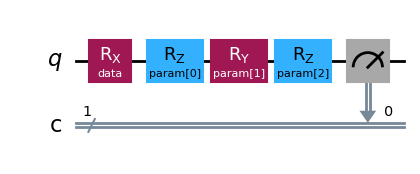

In [3]:
qc.draw('mpl')

## Define loss and accuracy functions needed for optimizing parameters¶

In [4]:
# calculate accuracy with L1-norm
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-2 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [5]:
# define function calculating the square mean = ((labels-predictions)**2)/N
def square_loss(labels, predictions):
    
    return (np.square(labels - predictions)).mean(axis=0)

In [6]:
# first approach: calculate loss by L2-norm
def loss_func(predictions):
    # This is a postprocessing step. Here we use a least squares metric
    # based on the predictions of the quantum circuit and the outputs
    # of the training data points.

    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

In [7]:
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()
num_shots = 10000

In [8]:
#Define your cost function, including any classical pre/postprocessing
def cost_fn(params):
    # We get the predictions of the quantum circuit for a specific
    # set of parameters along the entire input dataset
    # run our circuit with params and get predictions
    predictions = []
    for x in X:
        pub = (qc, [x, params[0], params[1], params[2]])
        job = sampler.run([pub], shots=num_shots)
        result = job.result()
        #print(result[0].data.c.get_counts())
        counts = result[0].data.c.get_counts()
        pred = 0.0
        if "1" in counts.keys():
            pred = counts["1"]/num_shots

        # shift range from [0.1] to [-1,1]
        predictions.append((pred*2) - 1.0)
        
    # We calculate the cost including any classical postprocessing
    #cost = loss_func(predictions)

    # We use the mean(L2) for optimization
    cost = square_loss(Y, predictions)
    return cost

## Load data and initialize parameters and bias

In [9]:
# define number of date points taken for training
num_datapoints = 20

In [10]:
# We create the training Data
X = np.linspace(0, 2*np.pi, num_datapoints) # 20 input datapoints from 0 to 2pi
# We tell the optimizer that this is an input datapoint,
# and not a parameter to optimize over.
#X.requires_grad = False
Y = np.sin(X) # The outputs for the input datapoints

# We create the test Data
# 20 test datapoints, shifted from the training data by 0.2
# Since we're not optimizing over the test data we
# don't need to specify requires_grad = False
X_test = np.linspace(0.2, 2*np.pi+0.2, num_datapoints)
Y_test = np.sin(X_test) # The outputs for the test datapoints

In [11]:
#params = np.array([0.1,0.1,0.1],requires_grad=True)
params = np.array([0.1,0.1,0.1])

## Instantiate Optimizer and start training

In [12]:
# test
cost = cost_fn(params)
print(cost)

0.9902290209327103


In [13]:
from scipy.optimize import minimize

In [14]:
init_params = np.array([0.1, 0.1, 0.1])

In [15]:
# Over each step the parameters change to give a better cost
opt_result = minimize(cost_fn, init_params, method="POWELL", tol=1e-7)

opt_result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.848535667440598e-05
       x: [ 1.634e+00  1.567e+00  6.479e-01]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00]]
    nfev: 174

In [16]:
opt_params = opt_result.x

## Evaluate results

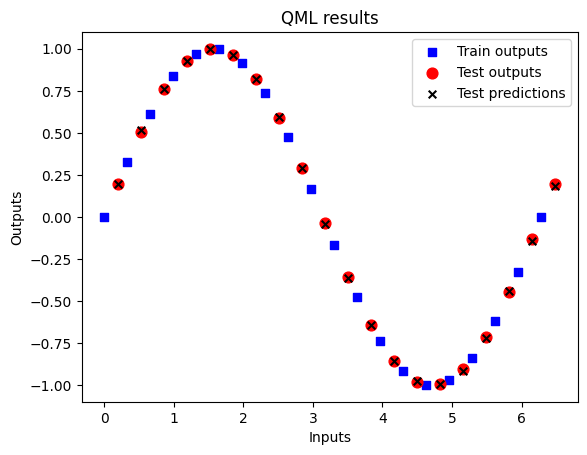

In [17]:
test_predictions = []
for x_test in X_test:
    pub = (qc, [x_test, opt_params[0], opt_params[1], opt_params[2]])
    job = sampler.run([pub], shots=num_shots)
    result = job.result()
    #print(result[0].data.c.get_counts())
    counts = result[0].data.c.get_counts()
    pred = 0.0
    if "1" in counts.keys():
        pred = counts["1"]/num_shots
    
    test_predictions.append((pred*2) - 1.0)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()

In [18]:
acc_val = accuracy(Y_test, test_predictions)
print(f"Accuracy: {acc_val}")

Accuracy: 0.8


## Try generalizing

In [19]:
X_test2 = np.linspace(0.2, 4*np.pi+0.2, num_datapoints*2)
Y_test2 = np.sin(X_test2) # The outputs for the test datapoints

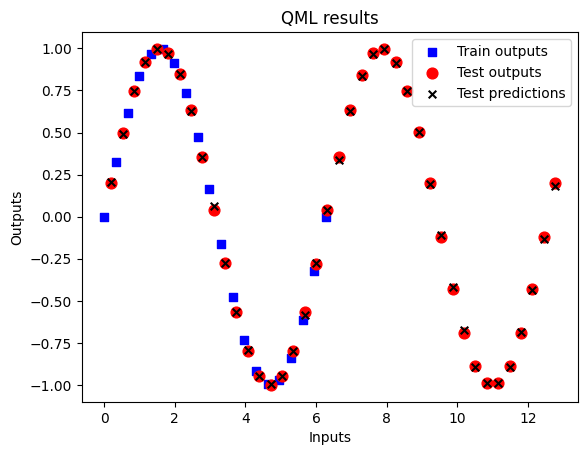

In [20]:
test_predictions = []
for x_test in X_test2:
    pub = (qc, [x_test, opt_params[0], opt_params[1], opt_params[2]])
    job = sampler.run([pub], shots=num_shots)
    result = job.result()
    #print(result[0].data.c.get_counts())
    counts = result[0].data.c.get_counts()
    pred = 0.0
    if "1" in counts.keys():
        pred = counts["1"]/num_shots
    test_predictions.append((pred*2) - 1.0)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test2,Y_test2, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test2,test_predictions, s=30, c='k', marker="x", label='Test predictions')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()